In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import cv2
from path import Path
from dface.core.detect import create_mtcnn_net, MtcnnDetector
import dface.core.vision as vision
from face_model import FaceModel as FM
from matplotlib import pyplot as plt
import sqlite3
import os, sys
import numpy as np
import pdb

C:\Users\Djori\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
FAIL = "FAIL"
FAIL_AGE_INT = -3
FAIL_MALE_INT = -4
FAIL_NOFACE_INT = -5
FAIL_INVALID_INT = -6
FAIL_GROUP = -7
FAIL_BASE_INT = 0
PASS = "PASS"
PASS_INT = 1
NOJUDGEMENT_INT = -1 #Image has been seen, but no judgement has been made
UNJUDGED_INT = -2 # Image has not been seen

RES_X = 112
RES_Y = 112
MINIMUM_PROBABILITY = 0.66
MALE = 1
FEMALE = 0
FAIL_OPEN_OR_CLOSED = FAIL
FAIL_ON_MALE = True
FAIL_ON_BABY = True
MINIMUM_AGE = 10

In [ ]:
DFacePath = Path("Path\\To\\Libraries\\DFace")
DFaceModelPath = "Path\\To\\Libraries\\insightface\\gender-age\\model\\model,0"

In [ ]:
class FaceArgs():
    def __init__(self, gpu=0, size_x=RES_X, size_y=RES_Y, ga_model=DFaceModelPath, det=0, threshold=1.24):
        self.gpu = gpu
        self.image_size=f"{size_x},{size_y}"
        self.image="./Tom_Hanks_54745.png"
        self.ga_model = ga_model
        self.det=det
        self.model = ""
        self.threshold=threshold

In [ ]:
def setup():
    pnet, rnet, onet = create_mtcnn_net(p_model_path=DFacePath/'model_store'/'pnet_epoch.pt', r_model_path=DFacePath/'model_store'/'rnet_epoch.pt', o_model_path=DFacePath/'model_store'/'onet_epoch.pt', use_cuda=True)
    facedetector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=24)
    faceargs = FaceArgs()
    genderdetector = FM(faceargs)
    return facedetector, genderdetector

In [ ]:
facedetector, genderdetector = setup()

In [ ]:
def mm2(p):
    img = cv2.imread(DFacePath/p)
    img_bg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxs, landmarks = facedetector.detect_face(img)
    print(bboxs)
    vision.vis_face(img_bg,bboxs,landmarks)

In [9]:
mm2("path/w6.jpg")

In [10]:
def extract_bbox(img, bbox):
    x0,y0,x1,y1, _ = bbox
    h = img.shape[0]
    w = img.shape[1]
    h0 = math.ceil(max(0, y0))
    w1 = math.ceil(min(w, x1))
    w0 = math.ceil(max(0, x0))
    h1 = math.ceil(min(h, y1))
    return img[h0:h1,w0:w1]

In [11]:
def resize(img, x, y):
    return cv2.resize(img, (x, y))

In [12]:
def recolor(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [13]:
# Make CV2 image 
# Find faces
def openimg(p, preface=False, Resize=False):
    pp = DFacePath/p if preface else p
    img = cv2.imread(pp)
    if Resize:
        # optionally attempt to resize to a managable size for our gpu
        print(img.shape)
    return img

In [14]:
def rot(i, d):
    rows = len(i)
    cols = len(i[0])
    M = cv2.getRotationMatrix2D((cols/2,rows/2),d,1)
    dst = cv2.warpAffine(i,M,(cols,rows))
    return dst

In [15]:
    def findrot(img, already_rotated, d, verbose=False):
        bboxs, _ = facedetector.detect_face(img)
        if len(bboxs):
            return bboxs, 0
        else:
            while already_rotated < 360 and already_rotated > -360 and (d != 0 and d!=360):
                if verbose: print("rotating d degrees: {0}".format(already_rotated))
                img = rot(img, d)
                already_rotated += d
                try:
                    bboxs, _ = facedetector.detect_face(img)
                    if len(bboxs) > 0:
                        return bboxs, already_rotated
                except:
                    if verbose: print("lol sup")
                    continue
        return [], already_rotated

In [16]:
def doshow(i, ga, d=0):
    img_bg = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    if not ga:
        print("failed to find a face")
    else:
        m = "Male" if ga[0] == MALE else "Female"
        print(f"age ~= {ga[1]}\nGender = {m}")
    img_bg = rot(img_bg, d)
    plt.imshow(img_bg)
    return

In [17]:
class SortResult():
    def __init__(self, label, invalid=0, ages="", num_people=0, male_present=0, baby_present=0):
        self.label = label
        self.invalid = invalid
        self.ages = ages
        self.num_people = num_people
        self.male_present = male_present
        self.baby_present = baby_present
        
    def __str__(self):
        s = f"label: {self.label}\ninvalid: {self.invalid}\nages: {self.ages}\nnum_people: {self.num_people}\nmale_present: {self.male_present}\nbaby_present: {self.baby_present}"
        return s

In [18]:
def sorter(p, failOnBaby=False, failOnMale=False, maximumPeople=0, minimumAge=0, show=True, d=0, verbose=False):
    people_count = 0
    male_present = False
    ages = []
    baby_present = False
    invalid = 0    
    try:
        #pdb.set_trace()
        i = openimg(p, True, Resize=True)
        if i is None:
            return SortResult(FAIL_INVALID_INT, invalid, ",".join(ages), people_count, male_present, baby_present)
        bboxs, deg = findrot(i, 0, d, verbose)#findFaces(i, d)
        people_count = len(bboxs)
        if people_count == 0:
            if show:
                doshow(i, None, deg)
                print("FAILED, no faces")
            return SortResult(FAIL_NOFACE_INT, invalid, ",".join(ages), people_count, male_present, baby_present)
        if verbose: print("??? -- 0")
        faces = [extract_bbox(i, x) for x in bboxs]
        if verbose: print("??? -- 1")
        if maximumPeople > 0 and len(faces) > maximumPeople:
            if show:
                doshow(i, None, deg)
                print("FAILED, too many people")
            #return FAIL_PEOPLECOUNT_INT
        resized = [resize(f, RES_X, RES_Y) for f in faces]
        if verbose: print("??? -- 2")
        iis = [genderdetector.get_input(x) for x in resized]
        if verbose: print("??? -- 3")
        probs = []
        for x in iis:
            try:
                gd = genderdetector.get_ga(x)
                if gd:
                    probs.append(gd)
            except:
                continue
        if not probs:
            if verbose: print("Failed somewhere")
            return SortResult(FAIL_INVALID_INT, 1, ",".join(ages), people_count, male_present, baby_present)
        if verbose: print("??? -- 4")
        for ga in probs:
            if ga[0] == MALE:
                male_present = True
            ages.append(str(ga[1]))
            if male_present and failOnMale:
                if show: 
                    doshow(i, gad, )
                    print("FAILED, males present")
                return SortResult(FAIL_MALE_INT, invalid, ",",join(ages), people_count, male_present, baby_present)
            if minimumAge > 0 and ga[1] < minimumAge:
                if show:
                    doshow(i, ga, deg)
                    print("FAILED, too young")
                return SortResult(FAIL_AGE_INT, invalid, ",".join(ages), people_count, male_present, baby_present)
        if show:
            doshow(i, ga, deg)      
            print("PASSED")
        return SortResult(NOJUDGEMENT_INT, invalid, ",".join(ages), people_count, male_present, baby_present)
    except Exception as e:
        print(e)
        #print("Failed to open the file")
        return SortResult(FAIL_INVALID_INT, invalid, ",".join(ages), people_count, male_present, baby_present)

(1080, 1080, 3)


C:\Users\Djori\Anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


age ~= 11
Gender = Female
PASSED
label: -1
invalid: 0
ages: 12,11
num_people: 2
male_present: False
baby_present: False


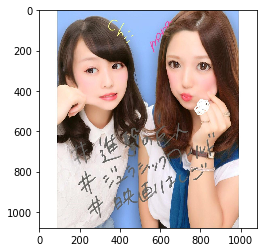

In [26]:
probs = sorter("path/to/images/groupa/person0/1060188700522660038.jpg", True, d=10)
print(probs)

In [20]:
def resize_image(img, scale):
    """
        resize image and transform dimention to [batchsize, channel, height, width]
    Parameters:
    ----------
        img: numpy array , height x width x channel
            input image, channels in BGR order here
        scale: float number
            scale factor of resize operation
    Returns:
    -------
        transformed image tensor , 1 x channel x height x width
    """
    height, width, channels = img.shape
    new_height = int(height * scale)     # resized new height
    new_width = int(width * scale)       # resized new width
    new_dim = (new_width, new_height)
    img_resized = cv2.resize(img, new_dim, interpolation=cv2.INTER_LINEAR)      # resized image
    return img_resized

def test(im):
    import dface.core.image_tools as image_tools
    import torch
    from torch.autograd.variable import Variable
    net_size = 12
    min_face_size = 12
    stride=2
    threshold=[0.6, 0.7, 0.7]
    scale_factor=0.709
    current_scale = float(net_size) / min_face_size
    im_resized = resize_image(im, current_scale)
    current_height, current_width, _ = im_resized.shape
    
    feed_imgs = []
    image_tensor = image_tools.convert_image_to_tensor(im_resized)
    feed_imgs.append(image_tensor)
    feed_imgs = torch.stack(feed_imgs)
    feed_imgs = Variable(feed_imgs)
    return image_tensor

In [21]:
ii = openimg("path/to/images/groupa/person1/1208270547245047035.jpg")


In [22]:
pp = test(ii)
pp[0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])